<a href="https://colab.research.google.com/github/ziatdinovmax/AISTEM_WORKSHOP_2020/blob/main/Day01/00_AutoencoderCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders for image cleaning

*  *Notebook prepared by Maxim Ziatdinov  (email: ziatdinovmax@gmail.com)*

*  *The simulated data (atomic coordinates) comes from MD calculations by Bobby Sumpter and Ayana Ghosh*



---


This notebook provides an example of training a custom Autoencoder for simple image cleaning (denoising) using [AtomAI](https://github.com/pycroscopy/atomai) trainers. Generally, autoencoders refer to the class of the neural networks that compress the data set to a small number of bottleneck features, and then expand back to original data size. The training aims to minimize information loss between the initial and reconstructed images via usual backpropagation. This process tends to select the relevant features in the data set and reject the noise, giving rise to applications for denoising.


---







Install AtomAI:

In [ ]:
!pip install atomai

Imports:

In [ ]:
import atomai as aoi
from atomai.nets import ConvBlock, UpsampleBlock
from atomai.utils import set_train_rng

import torch
import numpy as np
import matplotlib.pyplot as plt

Down(load) simulated data of graphene:

In [ ]:
# Download into VM storage
!wget -O "graphene_MD_imgs.npy" https://www.dropbox.com/s/r2cz8jqc9m19gaj/cropped_images_new.npy?dl=1

--2020-12-08 05:40:25--  https://www.dropbox.com/s/r2cz8jqc9m19gaj/cropped_images_new.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/r2cz8jqc9m19gaj/cropped_images_new.npy [following]
--2020-12-08 05:40:25--  https://www.dropbox.com/s/dl/r2cz8jqc9m19gaj/cropped_images_new.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf27c4f7d23e02504452a6f0c56.dl.dropboxusercontent.com/cd/0/get/BEoQsyKghL4q9Qqi_blcovroSCpHm8wgpFsfhcZn-XenpEQxdDiaM-_8chknnNjN8ZAPAIupDscPT8WtrMUiL__PXc6x51X9jI2FdTWgqK5UNklpBXiifPK017HYIMR-a2M/file?dl=1# [following]
--2020-12-08 05:40:26--  https://ucf27c4f7d23e02504452a6f0c56.dl.dropboxusercontent.com/cd/0/get/BEoQsyKghL4q9Qqi_blcovroSCpHm8wgpFsfhcZn-XenpEQxdDiaM-_8chknnNjN8ZAPAIupDscPT8W

## Training denosing autoencoder for just one level of noise

Load data into the notebook:


In [ ]:
imgdata = np.load("graphene_MD_imgs.npy")[::3] # take ~1/3 of the data
print(imgdata.shape)

(2016, 256, 256)


Now let's corrupt our data with noise and then use a denoising autoencoder to reconstruct the original images.

In [ ]:
np.random.seed(42) # for reproducibility
# Add noise to data
imgdata_noisy = imgdata + np.random.normal(scale=8, size=imgdata.shape)
# Normalize to (0,1) so that stochastic gradient decent will behave nicely
norm = lambda x: (x - x.min()) / x.ptp()
imgdata, imgdata_noisy = norm(imgdata), norm(imgdata_noisy)

View selected pairs of images (images from the left subplot will be inputs into a neural network and images from the right subplot will be our targets)

Text(0.5, 1.0, 'Corrupted image')

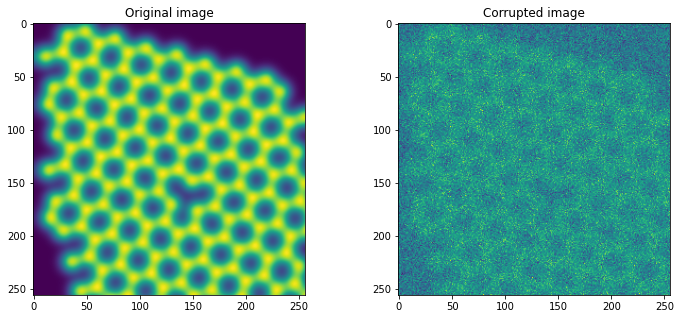

In [ ]:
k = 15

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(imgdata[k])
ax2.imshow(imgdata_noisy[k])
ax1.set_title("Original image")
ax2.set_title("Corrupted image")

Use AtomAI's utility function to convert to the format used by PyTorch:

In [ ]:
(imgdata, imgdata_noisy,
 imgdata_test, imgdata_noisy_test)  = aoi.utils.data_split(
     imgdata, imgdata_noisy, format_out="torch_float", channel="first")

Here we define our [denosing autoencoder](https://en.wikipedia.org/wiki/Autoencoder#Denoising_autoencoder_(DAE)) by combining AtomAI's building blocks for neural networks and native PyTorch modules:

In [ ]:
torch_encoder = torch.nn.Sequential(
    ConvBlock(ndim=2, nb_layers=1, input_channels=1, output_channels=8, batch_norm=True),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 8, 16, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 16, 32, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 32, 64, batch_norm=False)  # technically, this is a "bottleneck layer"
)

torch_decoder = torch.nn.Sequential(
    UpsampleBlock(ndim=2, input_channels=64, output_channels=64, mode="nearest"), # bilinear mode is better but leads to uncontrolled randomness on CPU
    ConvBlock(2, 2, 64, 32, batch_norm=False),
    UpsampleBlock(2, 32, 32, mode="nearest"),  # we can also use it to reduce numbe of "channels"
    ConvBlock(2, 2, 32, 16, batch_norm=False),
    UpsampleBlock(2, 16, 16, mode="nearest"),
    ConvBlock(2, 1, 16, 8, batch_norm=False),
    torch.nn.Conv2d(8, 1, 1) # vanilla 2D convolutional layer without activation
)

torch_DAE = torch.nn.Sequential(torch_encoder, torch_decoder)

Next we initialize AtomAI's trainer and pass our model to it:

In [ ]:
trainer = aoi.trainers.BaseTrainer()
trainer.set_model(torch_DAE)

Compile a trainer:

In [ ]:
# The next three lines are to ensure that we start from the same state of the model every time
set_train_rng(1)
trainer._reset_weights()
trainer._reset_training_history()

trainer.compile_trainer(
    (imgdata_noisy, imgdata, imgdata_noisy_test, imgdata_test), # training data
    loss="mse", training_cycles=500, swa=True  # training parameters
)

Finally, we train a model:

Epoch 1/500 ... Training loss: 0.0834 ... Test loss: 0.0715 ... GPU memory usage: 2787/16130
Epoch 100/500 ... Training loss: 0.0026 ... Test loss: 0.0048 ... GPU memory usage: 2787/16130
Epoch 200/500 ... Training loss: 0.002 ... Test loss: 0.0021 ... GPU memory usage: 2787/16130
Epoch 300/500 ... Training loss: 0.0013 ... Test loss: 0.001 ... GPU memory usage: 2787/16130
Epoch 400/500 ... Training loss: 0.0008 ... Test loss: 0.0007 ... GPU memory usage: 2787/16130
Epoch 500/500 ... Training loss: 0.0012 ... Test loss: 0.0019 ... GPU memory usage: 2787/16130
Model (final state) evaluation loss: 0.0019
Performing stochastic weights averaging...
Model (final state) evaluation loss: 0.0009
Plotting training history


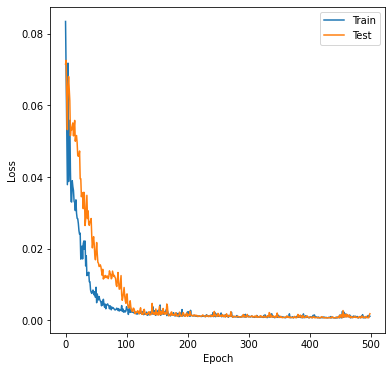

In [ ]:
trained_model = trainer.run()

Make a prediction with the trained model using AtomAI's predictor class:

In [ ]:
p = aoi.predictors.BasePredictor(trained_model, use_gpu=True)
prediction = p.predict(imgdata_noisy_test)

Text(0.5, 1.0, 'Difference')

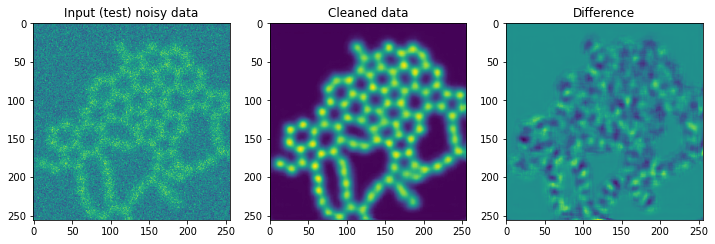

In [ ]:
k = 50
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.imshow(imgdata_noisy_test[k,0].cpu())
ax2.imshow(prediction[k,0].cpu())
ax3.imshow(imgdata_test[k,0].cpu() - prediction[k,0].cpu())
ax1.set_title("Input (test) noisy data")
ax2.set_title("Cleaned data")
ax3.set_title("Difference")

Looks clean!

However, there is a problem...  If we apply the trained to data with a different noise level (or even to clean data!) it won't produce any meaningful results. This is because we trained it to work only for one particular level of noise.

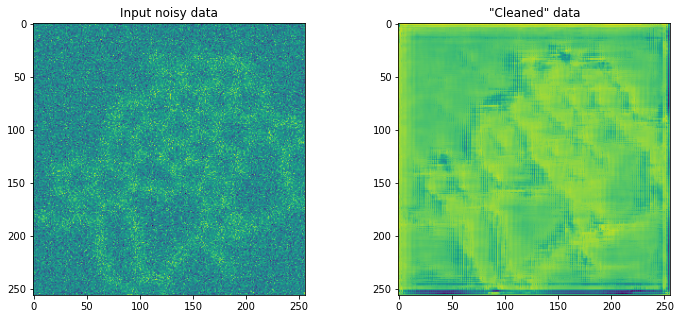

In [ ]:
img = imgdata_test[k:k+1]
img = img + np.random.normal(scale=.5, size=img.shape).astype(np.float32)

prediction = p.predict(img)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(img[0,0].cpu())
ax2.imshow(prediction[0,0].cpu())
ax1.set_title("Input noisy data")
ax2.set_title('"Cleaned" data')
plt.show()

## Training denosing autoencoder for images with varying levels of noise

Let's address the generalization problem of the current model by varying level of noise for each training image. First, reload our data

In [ ]:
imgdata = np.load("graphene_MD_imgs.npy")[::3] # take ~1/3 of the data

Now we apply different (randonly chosen) value of Gaussian noise to each image:

In [ ]:
np.random.seed(42)

imgdata_noisy = np.zeros_like(imgdata)
for i, img in enumerate(imgdata):
    s = np.random.randint(0, 1200)
    imgdata_noisy[i] = img + np.random.normal(scale=0.01*s, size=img.shape)

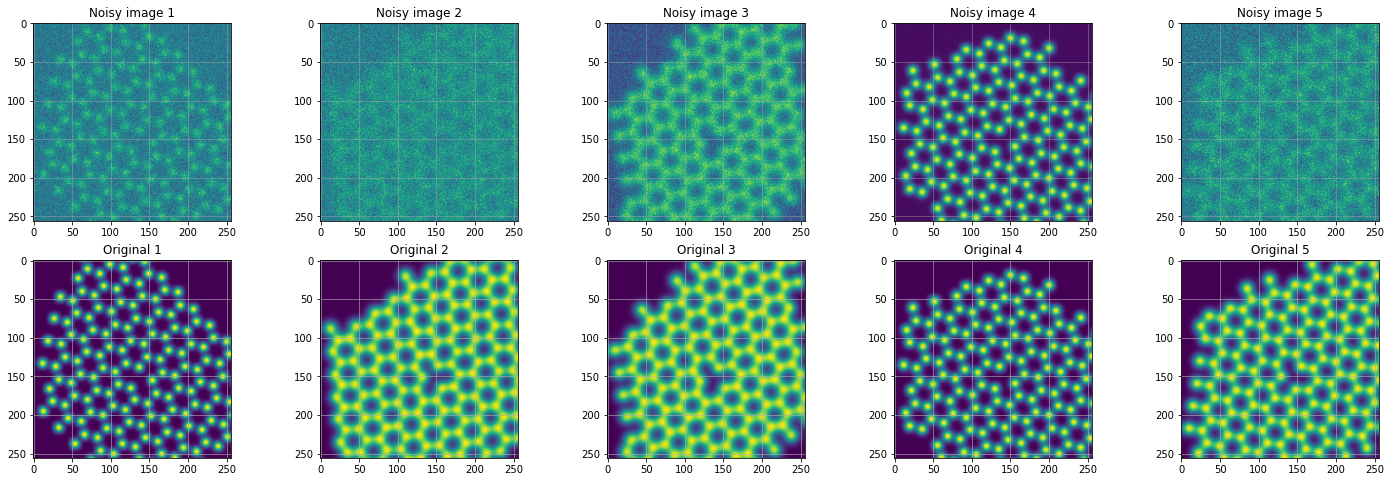

In [ ]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(imgdata_noisy[i-1])
    ax.set_title('Noisy image {}'.format(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(imgdata[i-1])
    ax.set_title('Original {}'.format(i))
    ax.grid(alpha=0.75)

Split into train and test sets and train a new model:

In [ ]:
(imgdata, imgdata_noisy,
 imgdata_test, imgdata_noisy_test)  = aoi.utils.data_split(
     imgdata, imgdata_noisy, format_out="torch_float", channel="first")

Epoch 1/2000 ... Training loss: 63.9253 ... Test loss: 67.3167 ... GPU memory usage: 2787/16130
Epoch 100/2000 ... Training loss: 2.7674 ... Test loss: 2.3042 ... GPU memory usage: 2787/16130
Epoch 200/2000 ... Training loss: 1.0962 ... Test loss: 1.9314 ... GPU memory usage: 2787/16130
Epoch 300/2000 ... Training loss: 1.0448 ... Test loss: 1.3924 ... GPU memory usage: 2787/16130
Epoch 400/2000 ... Training loss: 0.7649 ... Test loss: 0.822 ... GPU memory usage: 2787/16130
Epoch 500/2000 ... Training loss: 1.4497 ... Test loss: 1.0998 ... GPU memory usage: 2787/16130
Epoch 600/2000 ... Training loss: 0.6954 ... Test loss: 0.6232 ... GPU memory usage: 2787/16130
Epoch 700/2000 ... Training loss: 1.0116 ... Test loss: 1.5701 ... GPU memory usage: 2787/16130
Epoch 800/2000 ... Training loss: 0.9248 ... Test loss: 0.5236 ... GPU memory usage: 2787/16130
Epoch 900/2000 ... Training loss: 0.7361 ... Test loss: 0.987 ... GPU memory usage: 2787/16130
Epoch 1000/2000 ... Training loss: 1.3842 

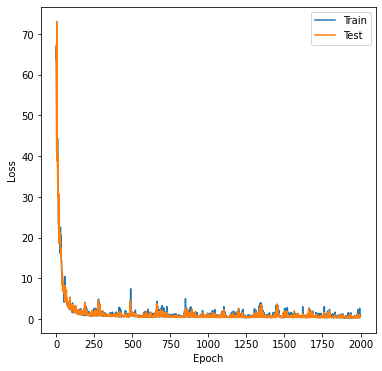

In [ ]:
# Re-initialize model
set_train_rng(1)
trainer._reset_weights()
trainer._reset_training_history()
# Compile and train
trainer.compile_trainer(
    (imgdata_noisy, imgdata, imgdata_noisy_test, imgdata_test), # training data
    loss="mse", training_cycles=2000, swa=True  # training parameters
)
trained_model_new = trainer.run()

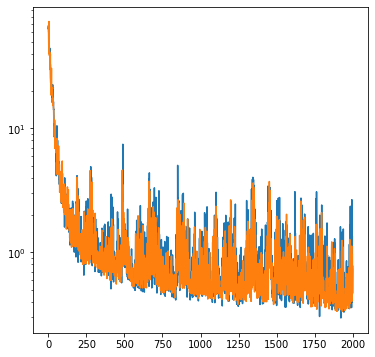

In [ ]:
# ame loss vs. training cycle plot bu on log scale
plt.figure(figsize=(6, 6))
plt.plot(trainer.loss_acc["train_loss"])
plt.plot(trainer.loss_acc["test_loss"])
plt.yscale("log")

Make a prediction with new model:

In [ ]:
p = aoi.predictors.BasePredictor(trained_model_new, use_gpu=True)
prediction = p.predict(imgdata_noisy_test)

Text(0.5, 1.0, 'Difference')

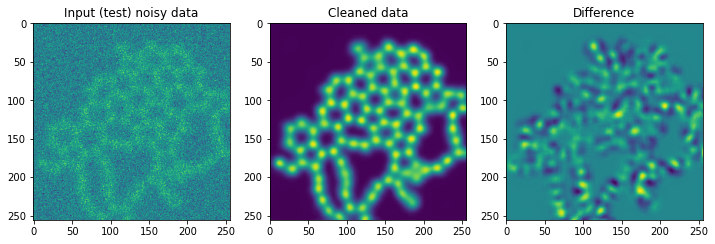

In [ ]:
k = 50
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.imshow(imgdata_noisy_test[k,0].cpu())
ax2.imshow(prediction[k,0].cpu())
ax3.imshow(imgdata_test[k,0].cpu() - prediction[k,0].cpu())
ax1.set_title("Input (test) noisy data")
ax2.set_title("Cleaned data")
ax3.set_title("Difference")

To make sure we do everything by the book, let's also create a separate valdiation set by loading part of the data that was not previously used either in training OR in test sets:

In [ ]:
imgdata = np.load("graphene_MD_imgs.npy")[:1000]
imgdata = np.array([im for i, im in enumerate(imgdata) if i % 3 !=0])

Corrupt it with slightly higher levels of noise:

In [ ]:
np.random.seed(42)
data_val_noisy = np.zeros_like(imgdata)
for i, img in enumerate(imgdata):
    s = np.random.randint(1200, 1300) # higher level of noise than used for training
    data_val_noisy[i] = img + np.random.normal(scale=0.01*s, size=img.shape)

Let's see how our model worked on the valdiation data

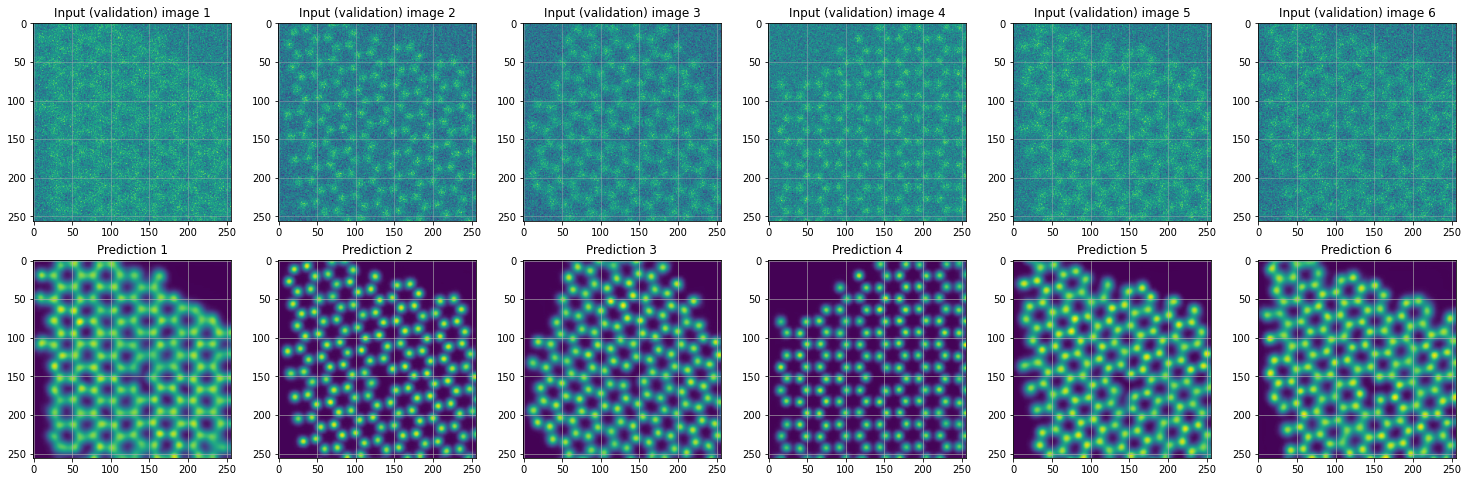

In [ ]:
n = 6 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    pred = p.predict(data_val_noisy[i-1:i, None].astype(np.float32))
    ax = fig.add_subplot(2, n, i)
    ax.imshow(data_val_noisy[i-1])
    ax.set_title('Input (validation) image {}'.format(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(pred[0, 0])
    ax.set_title('Prediction {}'.format(i))
    ax.grid(alpha=0.75)

Finally, let's make sure that the model does not magically find atoms from noise:

In [ ]:
noise_only = np.random.normal(size=(1, 1, 256, 256)).astype(np.float32)
prediction_from_noise = p.predict(noise_only)

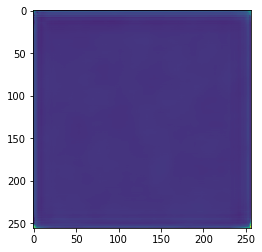

In [ ]:
plt.imshow(prediction_from_noise.squeeze());

The "cleaned" image contains no atoms (or anythin else) which is exactly what we want